In [1]:
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torch.autograd      as autograd

import numpy as np
import matplotlib.pyplot   as plt

from scipy.integrate import odeint

import abc

In [2]:
def diff(x, t, order):
    ones = torch.ones_like(t)
    der, = autograd.grad(x, t, create_graph=True, grad_outputs=ones)
    for i in range(1, order):
        der, = autograd.grad(der, t, create_graph=True, grad_outputs=ones)
    return der

In [3]:
class FCNN(nn.Module):
    """
    A fully connected neural network.
    """
    def __init__(self, n_hidden_units, n_hidden_layers, actv):
        """
        :param n_hidden_units: number of hidden units in each hidden layer
        :param n_hidden_layers: number of hidden layers
        :param actv: the activation layer used in each hidden layer
        """
        super(FCNN, self).__init__()
        
        layers = []
        layers.append(nn.Linear(1, n_hidden_units))
        layers.append(actv())
        for i in range(n_hidden_layers):
            layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            layers.append(actv())
        layers.append(nn.Linear(n_hidden_units, 1))
        self.NN = torch.nn.Sequential(*layers)

    def forward(self, t):
        x = self.NN(t)
        return x

In [4]:
class BoundaryCondition:
    def __init__(self):
        pass
    @abc.abstractmethod
    def enforce(self, t, x):
        pass
    
class CauchyBoundaryCondition(BoundaryCondition):
    """
    A Cauchy boundary condition: 
    x (t=t_0) = x_0
    x'(t=t_0) = x_0_prime
    """
    def __init__(self, t_0, x_0, x_0_prime=None):
        self.t_0, self.x_0, self.x_0_prime = t_0, x_0, x_0_prime
    def enforce(self, t, x):
        if self.x_0_prime: 
            return self.x_0 + (t-self.t_0)*self.x_0_prime + ( (1-torch.exp(-t+self.t_0))**2 )*x
        else:
            return self.x_0 + (1-torch.exp(-t+self.t_0))*x

class TwoPointDirichletBoundaryCondition(BoundaryCondition):
    """
    A two point Dirichlet boundary condition: 
    x(t=t_0) = x_0
    x(t=t_0) = x_1
    """
    def __init__(self, t_0, x_0, t_1, x_1):
        self.t_0, self.x_0, self.t_1, self.x_1 = t_0, x_0, t_1, x_1
    def enforce(self, t, x):
        t_tilde = (t-self.t_0) / (self.t_1-self.t_0)
        return self.x_0*(1-t_tilde) + self.x_1*t_tilde + (1-torch.exp((1-t_tilde)*t_tilde))*x

In [5]:
class ExampleGenerator:
    def __init__(self, size, t_min=0.0, t_max=1.0, method='uniform'):
        self.size = size
        self.t_min, self.t_max = t_min, t_max
        if   method=='uniform':
            self.examples = torch.zeros(self.size, requires_grad=True)
            self.get_examples = lambda: self.examples + torch.rand(self.size)*(self.t_max-self.t_min) + self.t_min
        elif method=='equally-spaced':
            self.examples = torch.linspace(self.t_min, self.t_max, self.size, requires_grad=True)
            self.get_examples = lambda: self.examples
        elif method=='equally-spaced-noisy':
            self.examples = torch.linspace(self.t_min, self.t_max, self.size, requires_grad=True)
            self.noise_mean = torch.zeros(self.size)
            self.noise_std  = torch.ones(self.size) * ( (t_max-t_min)/size ) / 4.0
            self.get_examples = lambda: self.examples + torch.normal(mean=self.noise_mean, std=self.noise_std)
        else:
            raise ValueError(f'Unknown method: {method}')

In [6]:
class Monitor:
    def __init__(self, t_min, t_max, check_every=100):
        %matplotlib notebook
        self.check_every = check_every
        self.fig = plt.figure(figsize=(20, 8))
        self.ax1 = self.fig.add_subplot(121)
        self.ax2 = self.fig.add_subplot(122)
        # input for plotting
        self.ts_plt =    np.linspace(t_min, t_max, 100) 
        # input for neural network
        self.ts_ann = torch.linspace(t_min, t_max, 100, requires_grad=True).reshape((-1, 1, 1)) 
    def check(self, net, ode, boundary_condition, loss_history):
        xs = net(self.ts_ann)
        xs = boundary_condition.enforce(self.ts_ann, xs)
        left, right = ode(xs, self.ts_ann)
        left, right = left.detach().numpy().flatten(), right.detach().numpy().flatten()
        xs = xs.detach().numpy().flatten()

        self.ax1.clear()
        self.ax1.plot(self.ts_plt, xs,    label='x(t) by NN')
        self.ax1.plot(self.ts_plt, left,  label='left-hand  side of ODE')
        self.ax1.plot(self.ts_plt, right, label='right-hand side of ODE')
        self.ax1.legend()
        self.ax1.set_title('solutions')

        self.ax2.clear()
        self.ax2.plot(loss_history)
        self.ax2.set_title('loss during training')
        self.ax2.set_ylabel('loss')
        self.ax2.set_xlabel('epochs')
        self.ax2.set_yscale('log')

        self.fig.canvas.draw()

In [7]:
def solve(ode, boundary_condition, t_min, t_max,
          net=None, example_generator=None, optimizer=None, criterion=None, batch_size=16, 
          max_epochs=100000, tol=1e-4,
          monitor=None):
    """
    Train a fully connected neural network to solve an ODE. It is hard coded to solve the ODE d^2x/dt^2 = -omega^2*x.
    The training is done using mini-batches.
    :param ode: an ode to be solved, it should be a function (x, t) -> left, right
    :param boundary_condition: the boundary condition, a BoundaryCondition instance
    :param net: a pytorch neural network, a nn.Module instance
    :param t_min: lower bound of the domain on which the ode is solved
    :param t_max: upper bound of the domain on which the ode is solved
    :param example_generator: a ExampleGenerator instance
    :param optimizer: a optimizer from pytorch.optim
    :param criterion: a loss function from pytorch.nn
    :param batch_size: the size of the minibatch
    :param max_epochs: the maximum number of epochs
    :param tol: the training stops if the loss is lower than this value
    :param monitor: a Monitor instance
    """
    
    # default values
    if not net: 
        net = FCNN(n_hidden_units=32, n_hidden_layers=3, actv=nn.Tanh)
    if not example_generator: 
        example_generator = ExampleGenerator(32, t_min, t_max, method='equally-spaced-noisy')
    if not optimizer:
        optimizer = optim.Adam(net.parameters(), lr=0.001)
    if not criterion:
        criterion = nn.MSELoss()
    if not monitor:
        monitor = Monitor(t_min, t_max, check_every=100)
    
    n_examples = example_generator.size
    if n_examples%batch_size != 0:
        # todo: I know this is stupid, I'll fix this later
        raise RuntimeError('Please choose a batch_size such that it is a factor of the size of the training set.')
    n_batches = n_examples//batch_size
    
    loss_history = []
    
    for epoch in range(max_epochs):
        loss_epoch = 0.0

        examples = example_generator.get_examples()
        ts_batches = examples.reshape((n_batches, batch_size, 1))
        for ts in ts_batches:     

            xs = net(ts)
            xs = boundary_condition.enforce(ts, xs)
            
            left, right = ode(xs, ts)
            loss = criterion(left, right)
            loss_epoch += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_history.append(loss_epoch/n_batches)
        if loss_history[-1] < tol: break
        
        if epoch%monitor.check_every == 0:
            monitor.check(net, ode, boundary_condition, loss_history)
    
    def solution(ts):
        if not isinstance(ts, torch.Tensor): ts = torch.tensor([ts], dtype=torch.float32)
        ts = ts.reshape(-1, 1)
        xs = net(ts)
        xs = boundary_condition.enforce(ts, xs)
        return xs
    if loss_history[-1] > tol:
        print('The solution has not converged.')
        
    return solution, loss_history

The user will need to specify the ODE to be solved including the boundary condition and the domain where this ODE is solved. They will get a solution function back, which is essentially t->x. For now, the most awkward part is that the user will need to write the ODE as a function which should conform to some implicit convention, but I feel that the extent of awkwardness is... acceptable? The following is an example of what I imagine the client code will be like.

<IPython.core.display.Javascript object>


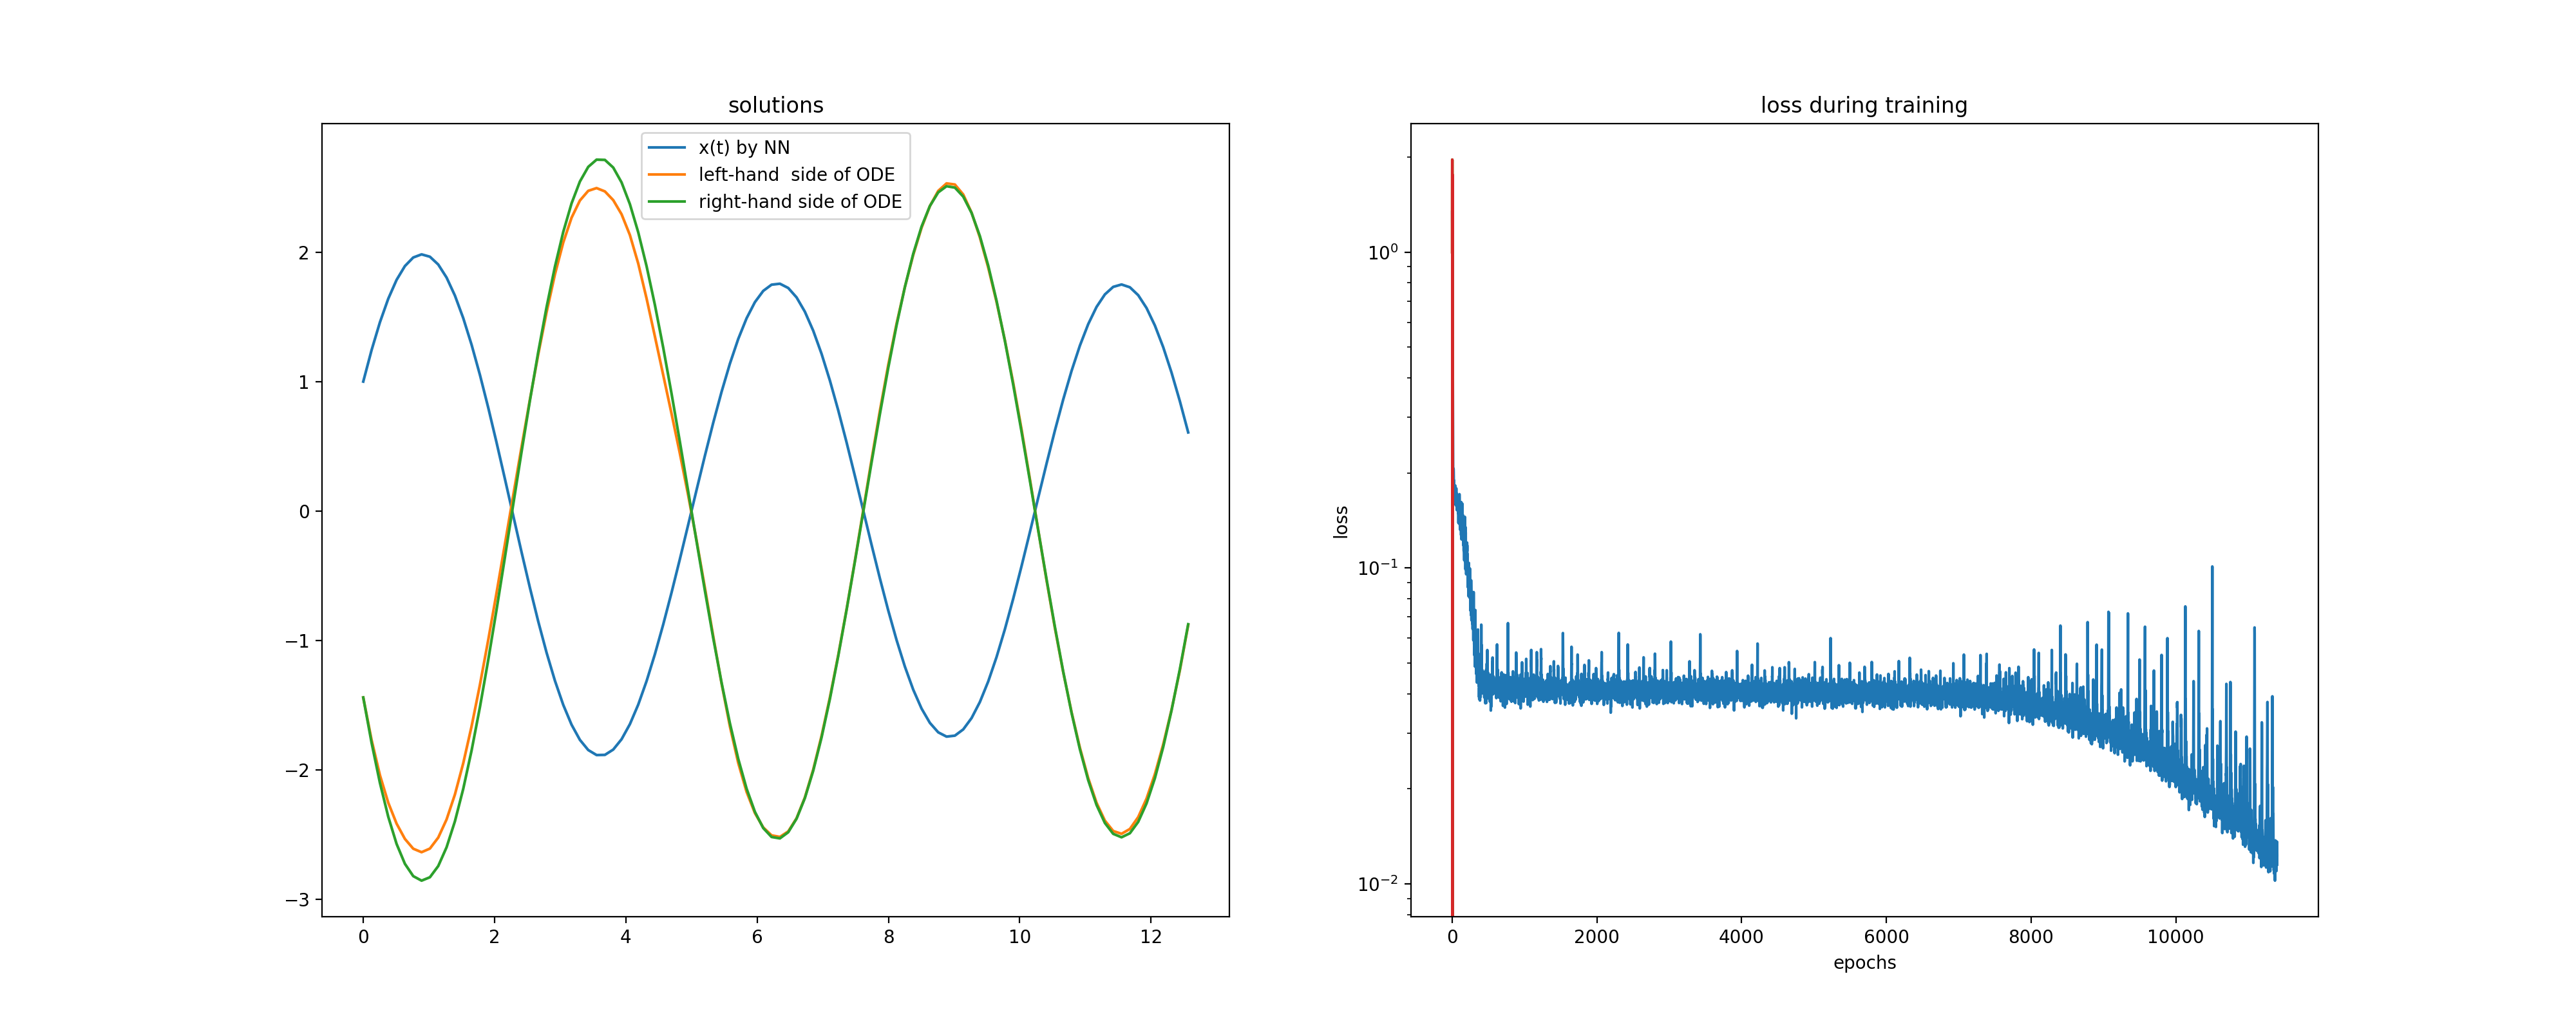

In [8]:
harmonic_oscillator = lambda x, t: (diff(x, t, order=2), -1.2**2 * x)

# cauchy_condition    = CauchyBoundaryCondition(           t_0=0.0, x_0=0.4, x_0_prime=-1.7)
dirichlet_condition = TwoPointDirichletBoundaryCondition(t_0=0.0, x_0=1.0, t_1=5.0, x_1=0.0)

solution, _ = solve(ode=harmonic_oscillator, boundary_condition=dirichlet_condition, t_min=0.0, t_max=4*np.pi,
                    tol=1e-2)

In [9]:
solution(3.52)

tensor([[-1.8713]], grad_fn=<AddBackward0>)